In [1]:
from scipy import io, signal
import matplotlib.pyplot as plt
import dtcwt
import numpy as np
import itertools
import pywt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [35]:
test_path = 'MLII/reformatted_dataset/normal/100m (0)_nsr.mat'
ta = io.loadmat(test_path)

In [36]:
print(ta['val'])

[[953 951 949 ... 940 943 944]]


In [37]:
print(ta)

{'val': array([[953, 951, 949, ..., 940, 943, 944]], dtype=int16)}


In [38]:
ta = ta['val']

In [39]:
print(type(ta))

<class 'numpy.ndarray'>


In [40]:
ta.shape

(1, 3600)

In [41]:
print(ta)

[[953 951 949 ... 940 943 944]]


In [42]:
import numpy as np
ta = np.array(ta)

In [43]:
ta = np.reshape(ta, (3600,))

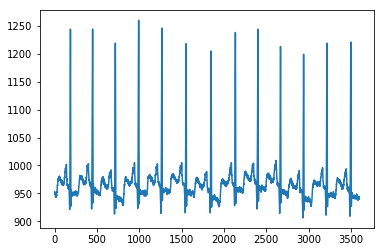

In [44]:
import matplotlib.pyplot as plt
plt.plot(ta)
plt.show()

In [53]:
def plot_ecg(path, tit):
    ta = io.loadmat(path)
    ta = ta['val']
    ta = np.array(ta)
    ta = np.reshape(ta, (ta.shape[1],))
    plt.plot(ta)
    plt.title(tit)
    plt.show()

In [79]:
def get_ecg(path):
    ta = io.loadmat(path)
    ta = ta['val']
    ta = np.array(ta)
    ta = np.reshape(ta, (ta.shape[1],))
    return ta

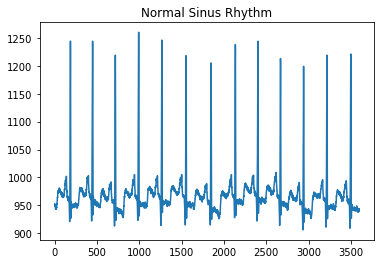

In [54]:
plot_ecg('MLII/reformatted_dataset/normal/100m (0)_nsr.mat', 'Normal Sinus Rhythm')

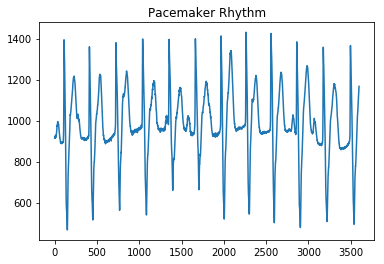

In [55]:
plot_ecg('MLII/reformatted_dataset/normal/107m (5)_pr.mat', 'Pacemaker Rhythm')

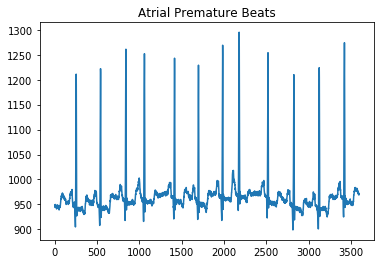

In [56]:
plot_ecg('MLII/reformatted_dataset/arythmia/100m (0)_apb.mat', 'Atrial Premature Beats')

In [57]:
# arythmia detection

In [80]:
x = get_ecg('MLII/reformatted_dataset/arythmia/100m (0)_apb.mat')

In [81]:
from pywt import wavedec
coeffs = wavedec(x, 'db4', level=2)
cA2, cD2, cD1 = coeffs

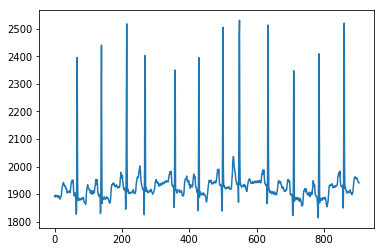

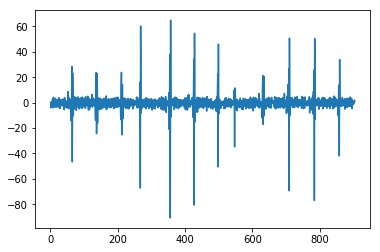

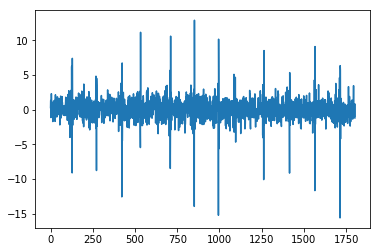

In [82]:
plt.plot(cA2)
plt.show()

plt.plot(cD2)
plt.show()

plt.plot(cD1)
plt.show()

In [83]:
# data process
import glob

nx = []
ax = []

for f in glob.glob('MLII/reformatted_dataset/normal/*.mat'):
    nx.append(get_ecg(f))
    

for f in glob.glob('MLII/reformatted_dataset/arythmia/*mat'):
    ax.append(get_ecg(f))

In [85]:
print(len(nx))
print(len(ax))

328
83


In [77]:
import pandas as pd
from numpy.linalg import LinAlgError
from statsmodels.tsa.stattools import adfuller
#1
def AE(x): # Absolute Energy
    x = np.asarray(x)
    return sum(x * x)

#2
def SM2(y):
    #t1 = time.time()
    f, Pxx_den = signal.welch(y)
    sm2 = 0
    n = len(f)
    for i in range(0,n):
        sm2 += Pxx_den[i]*(f[i]**2)
    
    #t2 = time.time()
    #print('time: ', t2-t2)
    return sm2


#3
def LOG(y):
    n = len(y)
    return np.exp(np.sum(np.log(np.abs(y)))/n)

#4
def WL(x): # WL in primary manuscript
    return np.sum(abs(np.diff(x)))
#6
def AC(x, lag=5): # autocorrelation

    """
     [1] https://en.wikipedia.org/wiki/Autocorrelation#Estimation

    """
    # This is important: If a series is passed, the product below is calculated
    # based on the index, which corresponds to squaring the series.
    if type(x) is pd.Series:
        x = x.values
    if len(x) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(x)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # Return the normalized unbiased covariance
    return sum_product / ((len(x) - lag) * np.var(x))

#7
def BE(x, max_bins=30): # binned entropy
    hist, bin_edges = np.histogram(x, bins=max_bins)
    probs = hist / len(x)
    return - np.sum(p * np.math.log(p) for p in probs if p != 0)
#15
def SE(x): # sample entropy
    """
    [1] http://en.wikipedia.org/wiki/Sample_Entropy
    [2] https://www.ncbi.nlm.nih.gov/pubmed/10843903?dopt=Abstract
    """
    x = np.array(x)

    sample_length = 1 # number of sequential points of the time series
    tolerance = 0.2 * np.std(x) # 0.2 is a common value for r - why?

    n = len(x)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((1, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((1, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = x[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[0]))

    # sample entropy = -1 * (log (A/B))
    similarity_ratio = A / B
    se = -1 * np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se[0]

#16
def TRAS(x, lag=5):
    # time reversal asymmetry statistic
    """
    |  [1] Fulcher, B.D., Jones, N.S. (2014).
    |  Highly comparative feature-based time-series classification.
    |  Knowledge and Data Engineering, IEEE Transactions on 26, 3026–3037.
    """
    n = len(x)
    x = np.asarray(x)
    if 2 * lag >= n:
        return 0
    else:
        return np.mean((np.roll(x, 2 * -lag) * np.roll(x, 2 * -lag) * np.roll(x, -lag) -
                        np.roll(x, -lag) * x * x)[0:(n - 2 * lag)])
    
    
#17    
def VAR(x): # variance 
    return np.var(x)

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [89]:
len(nx[0])

3600

In [90]:
def get_A(x):
    coeffs = wavedec(x, 'db4', level=2)
    cA2, cD2, cD1 = coeffs
    return cA2

In [91]:
len(get_A(nx[0]))

905

In [92]:
print(len(nx))

328


In [97]:
import time
fx = []
y = []

t1 = time.time()
for i in range(len(nx)):
    cf = []
    cf.append(AE(get_A(nx[i])))
    cf.append(SM2(get_A(nx[i])))
    cf.append((LOG(get_A(nx[i]))))
    cf.append((WL(get_A(nx[i]))))
    cf.append((AC(get_A(nx[i]))))
    cf.append(((BE(get_A(nx[i])))))
    cf.append((SE(get_A(nx[i]))))
    cf.append((TRAS(get_A(nx[i]))))
    cf.append((VAR(get_A(nx[i]))))
    fx.append(cf)
    y.append(1)
    print('.', end = '')
    
t2 = time.time()
print(t2-t1)

........................................................................................................................................................................................................................................................................................................................................356.2488446235657


In [99]:
print(len(fx))
print(len(y))

328
328


In [100]:
print(len(fx[0]))

9


In [101]:
t1 = time.time()
for i in range(len(ax)):
    cf = []
    cf.append(AE(get_A(ax[i])))
    cf.append(SM2(get_A(ax[i])))
    cf.append((LOG(get_A(ax[i]))))
    cf.append((WL(get_A(ax[i]))))
    cf.append((AC(get_A(ax[i]))))
    cf.append(((BE(get_A(ax[i])))))
    cf.append((SE(get_A(ax[i]))))
    cf.append((TRAS(get_A(ax[i]))))
    cf.append((VAR(get_A(ax[i]))))
    fx.append(cf)
    y.append(0)
    print('.', end = '')
    
t2 = time.time()
print(t2-t1)

...................................................................................107.66113567352295


In [102]:
print(len(fx))
print(len(y))

411
411


In [103]:
import numpy as np
fx = np.array(fx, dtype = 'float32')

In [104]:
fx.shape

(411, 9)

In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fx)
print(scaler.mean_)
X_all = scaler.transform(fx)

print(np.mean(X_all))
print(np.std(X_all))

[3.3332989e+09 6.1880867e+04 1.9032684e+03 2.8959859e+04 1.7506865e-01
 2.3282073e+00 1.5716642e+00 1.1180159e+06 2.4038328e+04]
-1.1694692e-06
1.0


In [109]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_all, y, cv=5)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7272051167633496 0.1763962471741112


In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100)

scores = cross_val_score(knn, X_all, y, cv=5)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7980960880559274 0.007141157066570031


In [114]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

scores = cross_val_score(clf, X_all, y, cv=5)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7046854082998661 0.17689499484705223


In [130]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=None,
    min_samples_split=4, random_state=0)

scores = cross_val_score(clf, X_all, y, cv=5)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.734374535177748 0.2567492330745884


In [125]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=10)

scores = cross_val_score(clf, X_all, y, cv=5)
print('Accuracy: ', scores.mean(), scores.std() * 2)

Accuracy:  0.7055778670236501 0.31001940841309117
